#

In [3]:
# ================================
# STEP 0: IMPORT LIBRARIES
# ================================

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm

# Better visualization
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE = "/content/drive/MyDrive/satellite_property"
df = pd.read_excel(f"{BASE}/data/raw/train.xlsx")

df.sample(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9211,7785000260,20140709T000000,624800,3,2.00,2250,14274,1.0,0,0,...,8,1500,750,1964,0,98040,47.5762,-122.217,2820,13813
1482,8078570460,20140924T000000,305500,4,2.50,1850,7199,2.0,0,0,...,7,1850,0,1989,0,98031,47.4031,-122.172,1940,7432
9270,624110110,20150222T000000,1063000,5,4.50,4820,13165,2.0,0,0,...,11,3950,870,1990,0,98077,47.7295,-122.057,3880,13810
15496,3575305362,20141215T000000,517000,3,1.75,1740,10000,1.0,0,0,...,7,1740,0,1976,2009,98074,47.6170,-122.058,1350,7500
10045,8730000250,20150205T000000,360000,2,1.75,1340,1050,3.0,0,0,...,8,1340,0,2009,0,98133,47.7053,-122.343,1340,1090


In [6]:
df.shape


(16209, 21)

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

### Target Variable (Price) Analysis
Understand price distribution

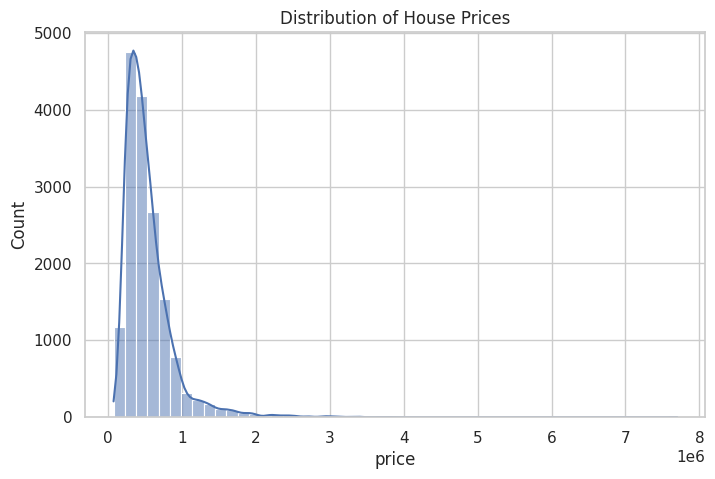

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.show()


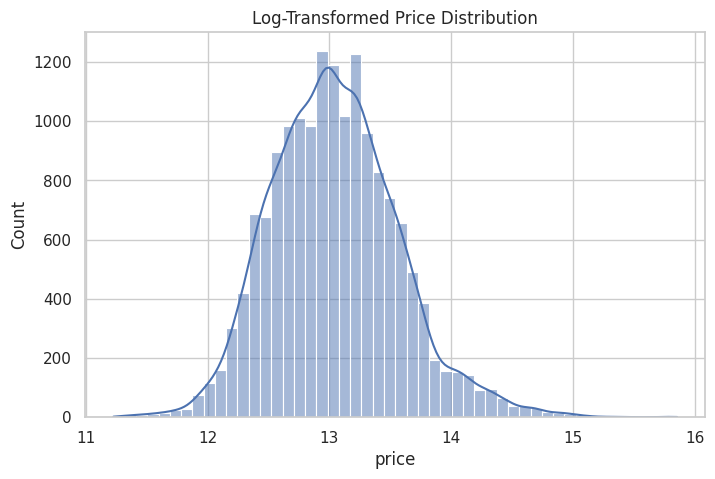

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df["price"]), bins=50, kde=True)
plt.title("Log-Transformed Price Distribution")
plt.show()


## Core Numerical Features vs Price
to Check linear/non-linear relationships

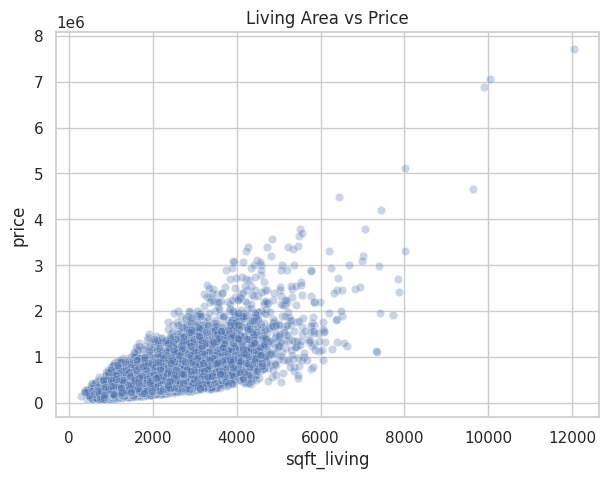

In [10]:
# sqft_living vs price
plt.figure(figsize=(7,5))
sns.scatterplot(x="sqft_living", y="price", data=df, alpha=0.3)
plt.title("Living Area vs Price")
plt.show()


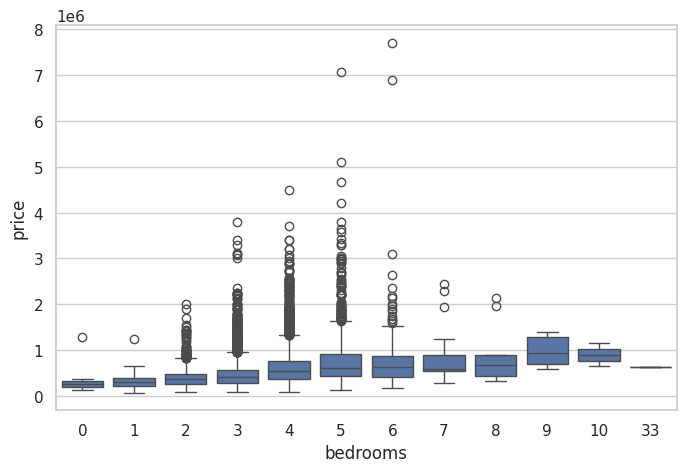

In [11]:
# bedrooms vs price
sns.boxplot(x="bedrooms", y="price", data=df)
plt.show()


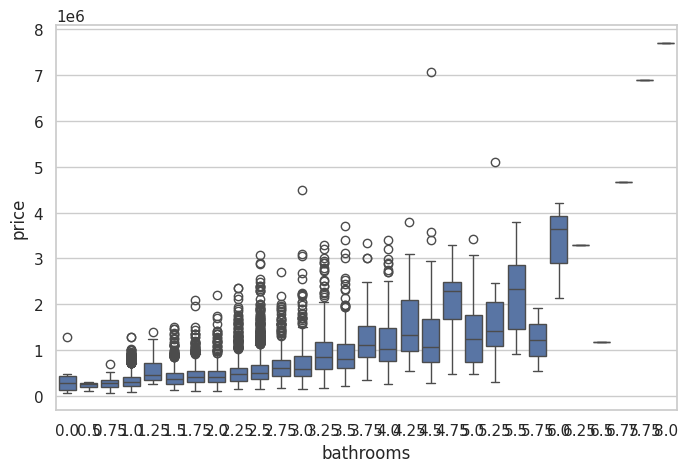

In [12]:
# bathrooms vs price
sns.boxplot(x="bathrooms", y="price", data=df)
plt.show()


### Quality & Condition Features

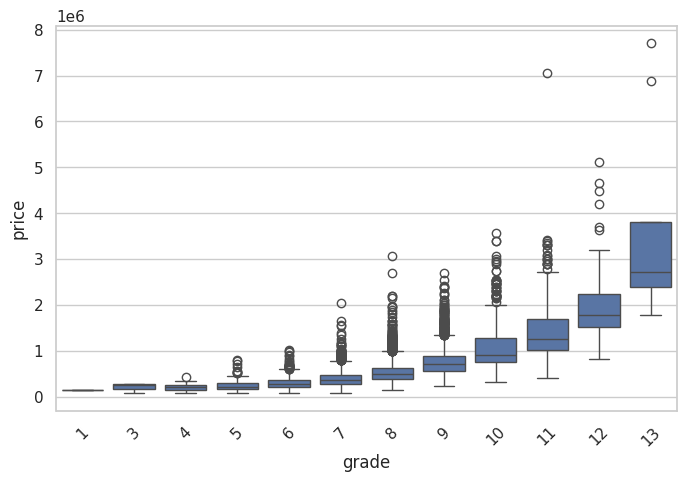

In [13]:
## Grade vs price
plt.figure(figsize=(8,5))
sns.boxplot(x="grade", y="price", data=df)
plt.xticks(rotation=45)
plt.show()

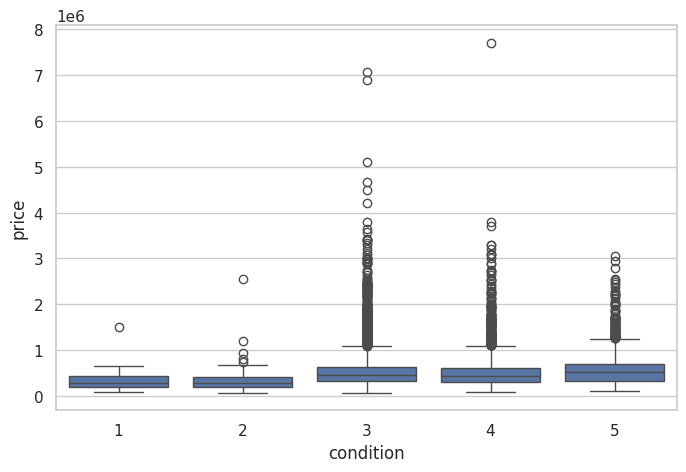

In [14]:
## Condition vs price
sns.boxplot(x="condition", y="price", data=df)
plt.show()


### Location-Based Analysis

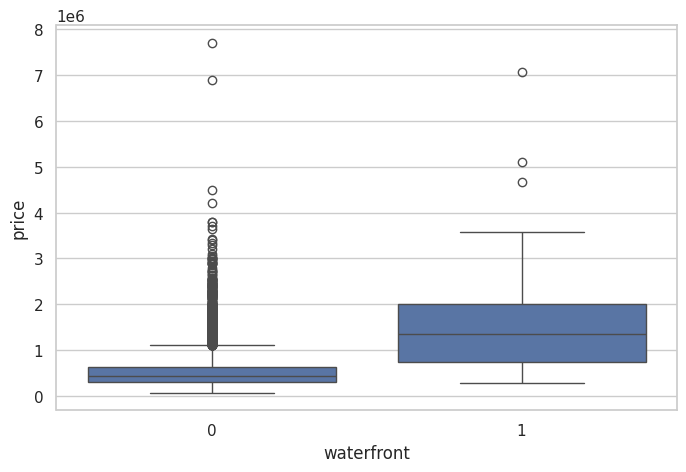

In [15]:
## Waterfront vs price
sns.boxplot(x="waterfront", y="price", data=df)
plt.show()

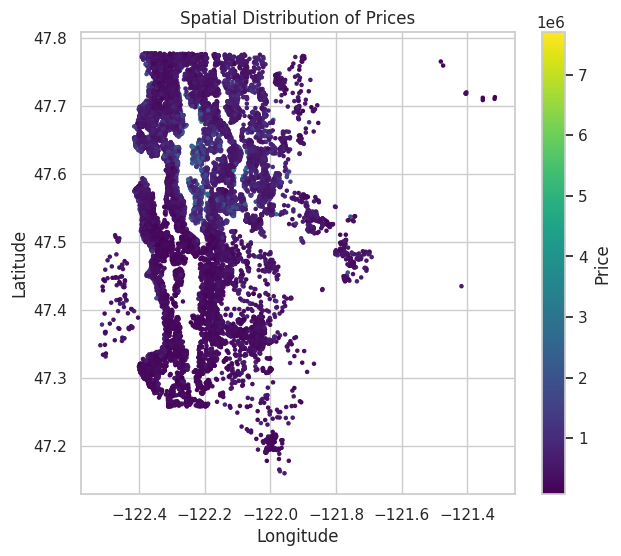

In [16]:
# Latitude / Longitude visualizatio
plt.figure(figsize=(7,6))
plt.scatter(df["long"], df["lat"], c=df["price"], cmap="viridis", s=5)
plt.colorbar(label="Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Prices")
plt.show()


### Neighborhood Density Features

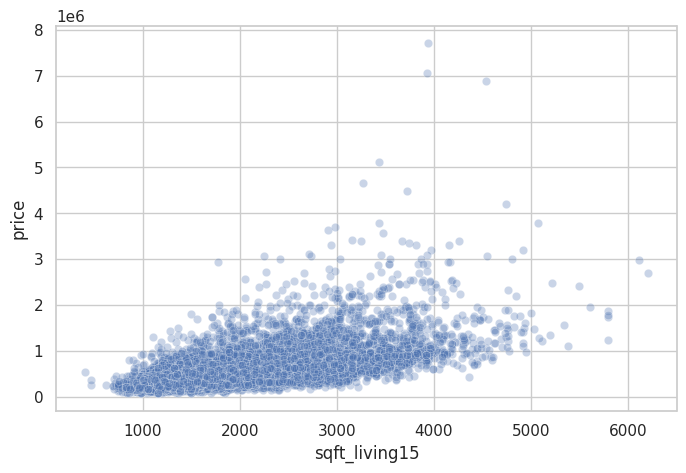

In [17]:
##sqft_living vs sqft_living15
sns.scatterplot(x="sqft_living15", y="price", data=df, alpha=0.3)
plt.show()

### Correlation Heatmap

Identify redundancy & important features

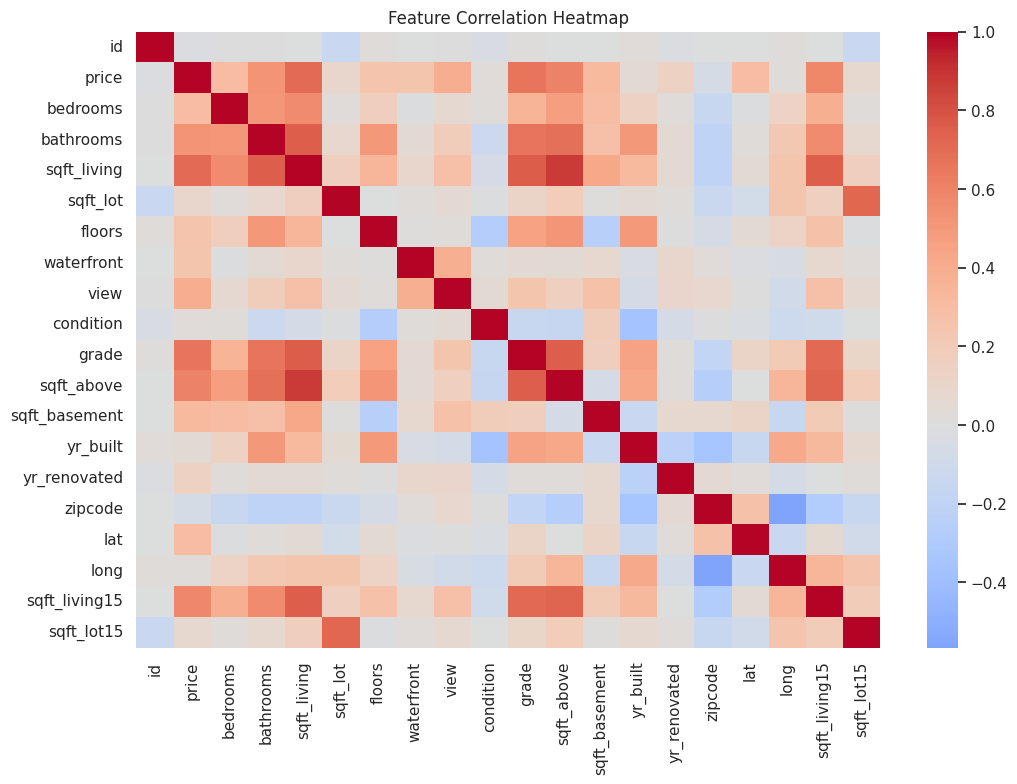

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df.drop('date', axis=1).corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# IMAGE EDA

In [19]:
#
BASE = "/content/drive/MyDrive/satellite_property"
IMG_DIR = f"{BASE}/data/images/train"

df = pd.read_excel(f"{BASE}/data/raw/train.xlsx")


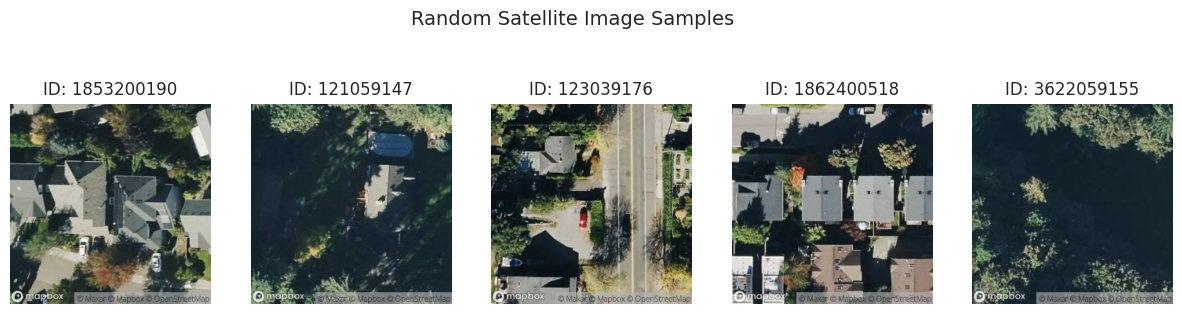

In [20]:
# RANDOM SATELLITE IMAGE SANITY CHECK
#Before using CNNs, verify images are valid (not blank, not wrong).
sample_ids = df.sample(5, random_state=42)["id"].values

plt.figure(figsize=(15,4))
for i, img_id in enumerate(sample_ids):
    img_path = os.path.join(IMG_DIR, f"{img_id}.png")
    img = Image.open(img_path)

    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"ID: {img_id}")

plt.suptitle("Random Satellite Image Samples", fontsize=14)
plt.show()

### LOW-PRICE vs HIGH-PRICE IMAGE COMPARISON

In [21]:
# Create price buckets
low_price_ids = df.nsmallest(5, "price")["id"].values
high_price_ids = df.nlargest(5, "price")["id"].values

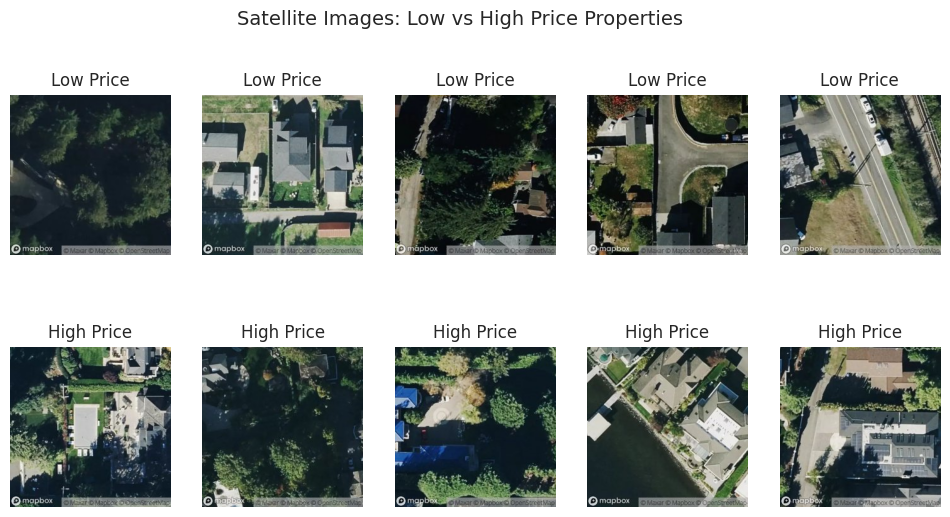

In [22]:
#Visual comparison plot

plt.figure(figsize=(12,6))

# Low price images
for i, img_id in enumerate(low_price_ids):
    img = Image.open(os.path.join(IMG_DIR, f"{img_id}.png"))
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Low Price")

# High price images
for i, img_id in enumerate(high_price_ids):
    img = Image.open(os.path.join(IMG_DIR, f"{img_id}.png"))
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.axis("off")
    plt.title("High Price")

plt.suptitle("Satellite Images: Low vs High Price Properties", fontsize=14)
plt.show()


In [23]:
# IMAGE GRID BY PRICE QUANTILES

#Create quantiles
df["price_quantile"] = pd.qcut(df["price"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

#Sample one image per quantile
quantile_samples = df.groupby("price_quantile").sample(2, random_state=42)


/tmp/ipython-input-4086469528.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_samples = df.groupby("price_quantile").sample(2, random_state=42)


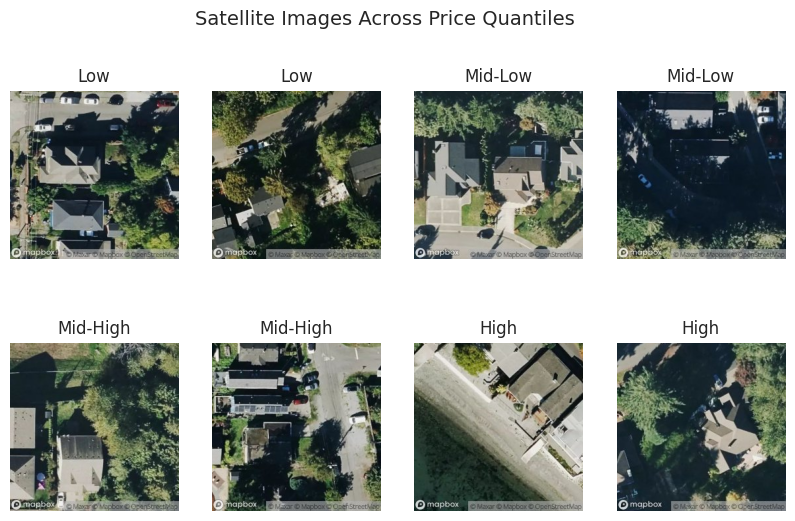

In [24]:
# Plot
plt.figure(figsize=(10,6))

for i, row in enumerate(quantile_samples.itertuples()):
    img = Image.open(os.path.join(IMG_DIR, f"{row.id}.png"))
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(row.price_quantile)

plt.suptitle("Satellite Images Across Price Quantiles", fontsize=14)
plt.show()


### SIMPLE GREENERY / COLOR ANALYSIS

In [25]:
#Function to estimate greenery
def green_ratio(image):
    img = np.array(image)
    green_pixels = (img[:,:,1] > img[:,:,0]) & (img[:,:,1] > img[:,:,2])
    return green_pixels.mean()

In [26]:
#Compute greenery for samples
sample_df = df.sample(200, random_state=42).copy()

ratios = []
for _, row in sample_df.iterrows():
    img = Image.open(os.path.join(IMG_DIR, f"{row['id']}.png"))
    ratios.append(green_ratio(img))

sample_df["green_ratio"] = ratios

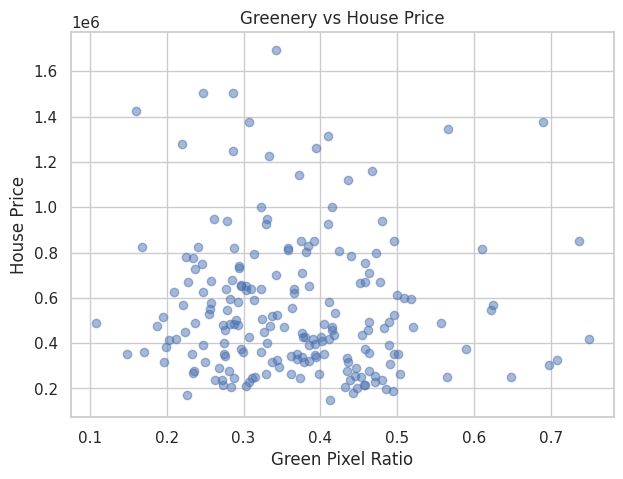

In [27]:
# Plot greenery vs price
plt.figure(figsize=(7,5))
plt.scatter(sample_df["green_ratio"], sample_df["price"], alpha=0.5)
plt.xlabel("Green Pixel Ratio")
plt.ylabel("House Price")
plt.title("Greenery vs House Price")
plt.show()